# ENG 최종 코드

In [5]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_A'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)__page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'\d{1,2}\s*대화|\d{1,2}\n\밑줄|\d{1,2}\n\다음')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

patterns = [pattern1, pattern2, pattern3]

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # y 좌표로 정렬
        found_patterns.sort(key=lambda b: b[0][0][1])

        # 정렬된 결과 출력
        print("Sorted patterns by y-coordinate:")
        for pattern in found_patterns:
            print(pattern)

        # 첫 번째 패턴의 상단 y 좌표 구하기
        first_y_min = int(found_patterns[0][0][0][1])

        # 첫 번째 패턴이 y=15보다 큰 경우, 원본 이미지의 상단부터 첫 번째 패턴까지 자르기
        if first_y_min > 50:
            cropped_img = img[0:first_y_min:, :]

            # 결과 이미지 저장
            output_file = os.path.join(output_directory, f"{idx}_top_to_first.png")
            cv2.imwrite(output_file, cropped_img)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for i, (bbox1, text1, _) in enumerate(found_patterns):
            if i < len(found_patterns) - 1:
                bbox2, text2, _ = found_patterns[i + 1]

                # 첫 번째 패턴의 상단과 두 번째 패턴의 상단 사이의 이미지 부분 자르기
                x_min = min(int(bbox1[0][0]), int(bbox2[0][0]))
                y_min = min(int(bbox1[0][1]), int(bbox2[0][1]))
                x_max = max(int(bbox1[2][0]), int(bbox2[2][0]))
                y_max = max(int(bbox1[0][1]), int(bbox2[0][1]))

                cropped_img = img[y_min:y_max, x_min:]

            # 결과 이미지 저장
            # output_file = os.path.join(output_directory, f"{idx}_{i}.png")
            # cv2.imwrite(output_file, cropped_img)

                # 결과 이미지 저장 (found_patterns에서 숫자 추출하여 파일명으로 사용)
                pattern_number = re.findall(r'\d+', text1)[0]  # found_patterns에서 숫자 추출
                output_file = os.path.join(output_directory, f"{idx}_{pattern_number}_{i}.png")
                cv2.imwrite(output_file, cropped_img)

        # 마지막 패턴의 상단부터 원본 이미지의 끝까지 자르기
        last_bbox, last_text, _ = found_patterns[-1]
        x_min, y_min = int(last_bbox[0][0]), int(last_bbox[0][1])
        # y_min = int(last_bbox[0][1])
        cropped_img = img[y_min:-310, x_min:]

        # 결과 이미지 저장
        pattern_number = re.findall(r'\d+', text1)[0]  # found_patterns에서 숫자 추출
        output_file = os.path.join(output_directory, f"{idx}_{pattern_number}_{i}.png")
        cv2.imwrite(output_file, cropped_img)

    else:
        # 패턴이 발견되지 않으면 전체 이미지를 저장
        height, width, _ = img.shape
        cropped_img = img[0:height, 0:width]

        # 결과 이미지 저장 (파일명을 임의로 지정)
        output_file = os.path.join(output_directory, f"whole_image_{idx}.png")
        cv2.imwrite(output_file, cropped_img)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: [([[237, 305], [1153, 305], [1153, 349], [237, 349]], '1. 대화틀 듣고 남자의 마지막 말에 대한 여자의 응답으로 가장 적절한', 0.41740339820679806), ([[237, 801], [1153, 801], [1153, 845], [237, 845]], '2. 대화틀 듣고 여자의 마지막 말에 대한 남자의 응답으로 가장 적절한', 0.5802337998495376), ([[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]], '3. 다음올 듣고 여자가 하는 말의 목적으로 가장 적절한 것올 고르시오', 0.32069111035063286), ([[236, 1739], [1042, 1739], [1042, 1789], [236, 1789]], '4. 대화틀 듣고 여자의 의견으로 가장 적절한 것올 고르시오.', 0.3482642817253763), ([[237, 2192], [1087, 2192], [1087, 2236], [237, 2236]], '5. 대화틀 듣고 두 사람의 관계름 가장 잘 나타번 것올 고르시오', 0.281114620977647)]
Sorted patterns by y-coordinate:
([[237, 305], [1153, 305], [1153, 349], [237, 349]], '1. 대화틀 듣고 남자의 마지막 말에 대한 여자의 응답으로 가장 적절한', 0.41740339820679806)
([[237, 801], [1153, 801], [1153, 845], [237, 845]], '2. 대화틀 듣고 여자의 마지막 말에 대한 남자의 응답으로 가장 적절한', 0.5802337998495376)
([[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]], '3. 다음올 듣고 여자가 하는 말의 목적으로 가장 적절한 것올 고르시오', 0.32069111035063286)
([[236

KeyboardInterrupt: 

# 정규식으로 잘 찾는지 확인하는 코드

In [1]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_eng'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)__page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'\d{1,2}\s*대화|\d{1,2}\n\밑줄|\d{1,2}\n\다음')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

patterns = [pattern1, pattern2, pattern3]

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for (bbox, text, prob) in found_patterns:
            print(f"Pattern found at bbox {bbox}: {text}")

    # 추가적인 처리나 저장 코드를 여기에 추가할 수 있습니다.


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: [([[237, 305], [1153, 305], [1153, 349], [237, 349]], '1. 대화틀 듣고 남자의 마지막 말에 대한 여자의 응답으로 가장 적절한', 0.41740339820679806), ([[237, 801], [1153, 801], [1153, 845], [237, 845]], '2. 대화틀 듣고 여자의 마지막 말에 대한 남자의 응답으로 가장 적절한', 0.5802337998495376), ([[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]], '3. 다음올 듣고 여자가 하는 말의 목적으로 가장 적절한 것올 고르시오', 0.32069111035063286), ([[236, 1739], [1042, 1739], [1042, 1789], [236, 1789]], '4. 대화틀 듣고 여자의 의견으로 가장 적절한 것올 고르시오.', 0.3482642817253763), ([[237, 2192], [1087, 2192], [1087, 2236], [237, 2236]], '5. 대화틀 듣고 두 사람의 관계름 가장 잘 나타번 것올 고르시오', 0.281114620977647)]
Pattern found at bbox [[237, 305], [1153, 305], [1153, 349], [237, 349]]: 1. 대화틀 듣고 남자의 마지막 말에 대한 여자의 응답으로 가장 적절한
Pattern found at bbox [[237, 801], [1153, 801], [1153, 845], [237, 845]]: 2. 대화틀 듣고 여자의 마지막 말에 대한 남자의 응답으로 가장 적절한
Pattern found at bbox [[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]]: 3. 다음올 듣고 여자가 하는 말의 목적으로 가장 적절한 것올 고르시오
Pattern found at bbox [[236, 1739], [1042, 1739

# 이미지 영역 확인 코드

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[14, 21], [67, 21], [67, 61], [14, 61]], '39', 0.9998941287580946),
 ([[69, 111], [345, 111], [345, 144], [69, 144]],
  'That may seem like',
  0.9328011745143718),
 ([[372, 108], [907, 108], [907, 148], [372, 148]],
  'lot until you consider that the average',
  0.9417687437512726),
 ([[63, 155], [907, 155], [907, 198], [63, 198]],
  'native living in the Amazonas of Venezuela has roughly 1,600',
  0.5591906057013576),
 ([[66, 204], [413, 204], [413, 244], [66, 244]],
  'species, a full third more',
  0.9750557360842057),
 ([[70, 276], [916, 276], [916, 319], [70, 319]],
  'Clearly there is no shortage of bacteria in our gut, which can',
  0.7530585675130673),
 ([[41, 325], [407, 325], [407, 362], [41, 362]],
  'make this next statement',
  0.6891920941642175),
 ([[441, 325], [746, 325], [746, 362], [441, 362]],
  'little hard to believe.',
  0.5192276025173173),
 ([[862, 328], [917, 328], [917, 361], [862, 361]], 'Our', 0.999670057772387),
 ([[95, 371], [750, 371], [750, 415], [95

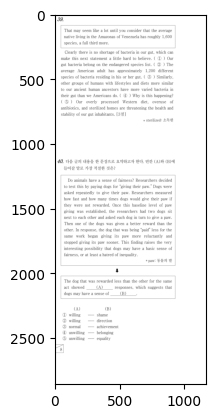

In [4]:
from matplotlib.pyplot import imshow
from PIL import Image

f_name = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped\2015_G1_11_ENG_right__page6.png'

%matplotlib inline
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

import easyocr

# easy-ocr
reader = easyocr.Reader(['ko','en'])
txt = reader.readtext(f_name)
txt